# Convolutional Neural Network  
  
Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### ----- PARAMETERS -----  
p: padding  
k: kernel size  
I: Input matrix size  
O: Output matrix size

In [2]:
# Convolution parameters
kernel_conv = 5
padding_conv = 2
stride_conv = 1
dilation_conv = 1

# MaxPooling parameters
kernel_pool = 2

###  ----- MODEL -----  
3 Convolutional layers with dropout and max-pooling, 1 final fully connected layer

In [3]:
class CNN(nn.Module):
    def __init__(self, out_1=16, out_2=32, dropout_rate=0.3, kernel_size=kernel_conv, padding=padding_conv, stride=stride_conv, dilation=dilation_conv):
        super(CNN, self).__init__()

        # First convolutional layer
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation)
        self.maxpool1 = nn.MaxPool2d(kernel_size=kernel_pool)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        
        # Second convolutional layer
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.maxpool2 = nn.MaxPool2d(kernel_size=kernel_pool)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        # Third convolutional layer
        self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_2, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.maxpool3 = nn.MaxPool2d(kernel_size=kernel_pool)
        self.dropout3 = nn.Dropout(p=dropout_rate)
        
        # Fully connected layer
        self.fc1 = nn.Linear(out_2 * 16 * 16, len(dataset.classes))  # Adjusted for the output of three pooling layers. Dataset will be defined later
        self.dropout4 = nn.Dropout(p=dropout_rate)
    
    def forward(self, x):
        # First layer
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)

        # Second layer
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)

        # Third layer
        x = self.cnn3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)

        # Flattening and passing through the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.dropout4(x)
        x = self.fc1(x)

        return x


### ----- TRAINING THE MODEL -----

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (using ImageNet means and stds)
])

In [5]:
# Defining the dataset
dataset = datasets.ImageFolder(root="Tobacco3482-10", transform=transform)

In [6]:
# Splitting the dataset
train_size = int(0.8 * len(dataset))  # 80% for training
validation_size = len(dataset) - train_size  # 20% for validation
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

In [7]:
# Define the dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=32, shuffle=False)

In [8]:
# Set model parameters
model = CNN()

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

n_epochs=30

In [9]:
cost_list=[]
accuracy_list=[]

N_test=len(validation_dataset)
COST=0

def train_model(n_epochs, patience=5):
    cost_list = []
    accuracy_list = []
    val_loss_list = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        COST = 0
        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST += loss.item()

        cost_list.append(COST / len(train_loader))

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for x_test, y_test in validation_loader:
                z = model(x_test)
                loss = criterion(z, y_test)
                val_loss += loss.item()
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == y_test).sum().item()

        val_loss /= len(validation_loader)
        val_loss_list.append(val_loss)

        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        print(f'Epoch {epoch+1}/{n_epochs}, Training Loss: {COST / len(train_loader):.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping triggered")
            break

    return cost_list, val_loss_list, accuracy_list

We use this method of early stopping because it allows for more flexible and tolerant management of minor fluctuations in validation loss. By setting a "patience" parameter, the model can endure a certain number of epochs without improvements before stopping the training, avoiding premature terminations caused by random variations in the data. This approach enhances training efficiency and prevents overfitting, ensuring that the model does not overly adapt to noise or anomalies in the validation data.

In [11]:
# Train the model and retrieve loss data
train_loss, validation_loss, accuracy = train_model(n_epochs)

Epoch 1/30, Training Loss: 2.0291, Validation Loss: 1.7598, Accuracy: 0.3644
Epoch 2/30, Training Loss: 1.4958, Validation Loss: 1.4616, Accuracy: 0.4735
Epoch 3/30, Training Loss: 1.2652, Validation Loss: 1.2370, Accuracy: 0.5983
Epoch 4/30, Training Loss: 1.1327, Validation Loss: 2.2364, Accuracy: 0.1650
Epoch 5/30, Training Loss: 1.1353, Validation Loss: 1.2059, Accuracy: 0.6485
Epoch 6/30, Training Loss: 1.0357, Validation Loss: 1.4680, Accuracy: 0.5222
Epoch 7/30, Training Loss: 1.0537, Validation Loss: 1.0353, Accuracy: 0.6872
Epoch 8/30, Training Loss: 0.9057, Validation Loss: 1.0589, Accuracy: 0.6786
Epoch 9/30, Training Loss: 0.8978, Validation Loss: 1.0485, Accuracy: 0.6643
Epoch 10/30, Training Loss: 0.7669, Validation Loss: 0.9896, Accuracy: 0.7030
Epoch 11/30, Training Loss: 0.7452, Validation Loss: 0.9204, Accuracy: 0.7317
Epoch 12/30, Training Loss: 0.6967, Validation Loss: 0.9027, Accuracy: 0.7317
Epoch 13/30, Training Loss: 0.6925, Validation Loss: 0.9040, Accuracy: 0.

In [12]:
model_save_path = "/Users/simone/Desktop/Luiss /*Machine Learning/Reply project/Document-classification/CNN.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}") 

Model saved to /Users/simone/Desktop/Luiss /*Machine Learning/Reply project/Document-classification/CNN.pth


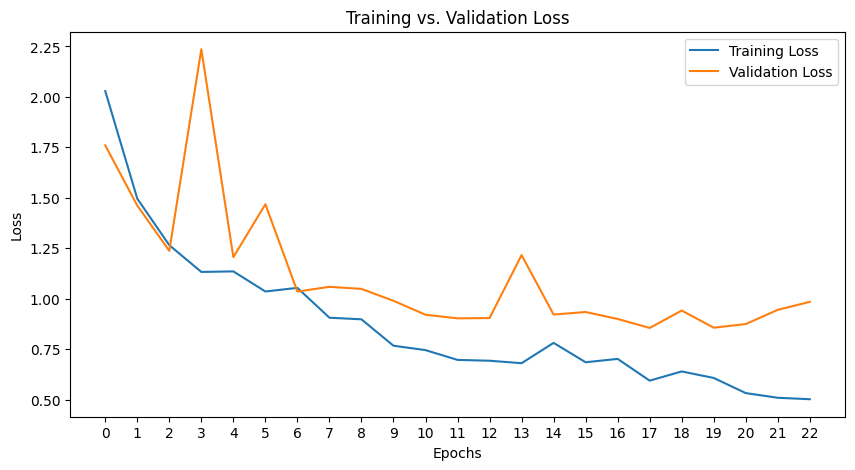

In [13]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(len(train_loss)))
plt.show()

The model performs efficiently up to epoch 18 (17 in the graph), with a gradual and steady decline in training loss and a validation loss that remains stable and comparable. This suggests a good ability of the model to adapt to the data without losing generalization. However, starting from epoch 19 (18 in the graph), a sudden spike in validation loss is observed, indicative of overfitting. This marked change implies that, although the model continued to improve on the training set, it began to lose the ability to generalize effectively on new data.

Warning: Being the model dependent on the random split of training set and validation set, if one were to rerun the training of the model, the number of epochs at which overfitting appears may vary. Nonetheless, it is important to highlight that the model achieves good performance within the first 18 epochs, a period during which overfitting does not yet seem to emerge.

### ----- MODEL ARCHITECTURE -----

In [14]:
import torchsummary

torchsummary.summary(model, input_size=(3, 128, 128)) # Get model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]           1,216
         MaxPool2d-2           [-1, 16, 64, 64]               0
           Dropout-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]          12,832
         MaxPool2d-5           [-1, 32, 32, 32]               0
           Dropout-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]          25,632
         MaxPool2d-8           [-1, 32, 16, 16]               0
           Dropout-9           [-1, 32, 16, 16]               0
          Dropout-10                 [-1, 8192]               0
           Linear-11                   [-1, 10]          81,930
Total params: 121,610
Trainable params: 121,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/

### ----- Hyperparameter Tuning -----

In [12]:
import optuna

def objective(trial):
    # Set up ranges for hyperparameters 
    out_1 = trial.suggest_int('out_1', 16, 64)
    out_2 = trial.suggest_int('out_2', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    n_epochs = trial.suggest_int('n_epochs', 5, 30)
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
    padding = trial.suggest_categorical('padding', [0, 1, 2])
    stride = trial.suggest_categorical('stride', [1, 2])
    dilation = trial.suggest_categorical('dilation', [1, 2])
    # Creazione del modello
    model = CNN(out_1=out_1, out_2=out_2, dropout_rate=dropout_rate, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    
    # Training and validation
    for epoch in range(n_epochs):
        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in validation_loader:
                z_val = model(x_val)
                loss = criterion(z_val, y_val)
                val_loss += loss.item()
    
    return val_loss / len(validation_loader)

In [ ]:
study = optuna.create_study(direction='minimize') 
study.optimize(objective, n_trials=1)

In [14]:
# Display of best parameters
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 1.2615507732738147
  Params: 
    out_1: 63
    out_2: 71
    dropout_rate: 0.4086010797806724
    lr: 4.1196489392434526e-05
    n_epochs: 16
    kernel_size: 3
    padding: 1
    stride: 1
    dilation: 1


In [15]:
# Definition of tuned parameters
out_1_tuned = study.best_trial.params['out_1']
out_2_tuned = study.best_trial.params['out_2']
dropout_rate_tuned = study.best_trial.params['dropout_rate']
lr_tuned = study.best_trial.params['lr']
n_epochs_tuned = study.best_trial.params['n_epochs']
kernel_size_tuned = study.best_trial.params['kernel_size']
padding_tuned = study.best_trial.params['padding']
stride_tuned = study.best_trial.params['stride']
dilation_tuned = study.best_trial.params['dilation']

In [16]:
# Definition of the model with tuned parameters
class CNN_tuned(nn.Module):
    def __init__(self, out_1=out_1_tuned, out_2=out_2_tuned, dropout_rate=dropout_rate_tuned, kernel_size=kernel_size_tuned, padding=padding_tuned, stride=stride_tuned, dilation=dilation_tuned):
        super(CNN_tuned, self).__init__()

        # First convolutional layer
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation)
        self.maxpool1 = nn.MaxPool2d(kernel_size=kernel_pool)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        
        # Second convolutional layer
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.maxpool2 = nn.MaxPool2d(kernel_size=kernel_pool)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        # Third convolutional layer
        self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_2, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.maxpool3 = nn.MaxPool2d(kernel_size=kernel_pool)
        self.dropout3 = nn.Dropout(p=dropout_rate)
        
        # Fully connected layer
        # Assuming 128x128 input, and each max-pooling halves the dimension:
        # 128 -> 64 -> 32 -> 16 after three max-pooling layers
        self.fc1 = nn.Linear(out_2 * 16 * 16, len(dataset.classes))  # Adjusted for the output of three pooling layers. Dataset will be defined later
        self.dropout4 = nn.Dropout(p=dropout_rate)
    
    def forward(self, x):
        # First layer
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)

        # Second layer
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)

        # Third layer
        x = self.cnn3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)

        # Flattening and passing through the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.dropout4(x)
        x = self.fc1(x)

        return x


# Set model parameters
model = CNN_tuned()

learning_rate = lr_tuned
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

n_epochs=n_epochs_tuned

In [17]:
# Train the model and retrieve loss data. Be sure to run the training function first
train_loss, validation_loss, accuracy = train_model(n_epochs)

Epoch 1/16, Training Loss: 2.2539, Validation Loss: 2.2480, Accuracy: 0.1793
Epoch 2/16, Training Loss: 2.1282, Validation Loss: 2.1573, Accuracy: 0.2152
Epoch 3/16, Training Loss: 2.0464, Validation Loss: 2.0789, Accuracy: 0.2238
Epoch 4/16, Training Loss: 1.9700, Validation Loss: 2.0124, Accuracy: 0.2582
Epoch 5/16, Training Loss: 1.8213, Validation Loss: 1.8725, Accuracy: 0.3544
Epoch 6/16, Training Loss: 1.6634, Validation Loss: 1.7447, Accuracy: 0.4333
Epoch 7/16, Training Loss: 1.5476, Validation Loss: 1.6492, Accuracy: 0.4562
Epoch 8/16, Training Loss: 1.4650, Validation Loss: 1.5896, Accuracy: 0.5065
Epoch 9/16, Training Loss: 1.3904, Validation Loss: 1.5054, Accuracy: 0.5308
Epoch 10/16, Training Loss: 1.3361, Validation Loss: 1.4999, Accuracy: 0.5337
Epoch 11/16, Training Loss: 1.2926, Validation Loss: 1.4286, Accuracy: 0.5940
Epoch 12/16, Training Loss: 1.2509, Validation Loss: 1.3865, Accuracy: 0.5768
Epoch 13/16, Training Loss: 1.1953, Validation Loss: 1.3576, Accuracy: 0.

In [18]:
# Save the trained model
model_save_path = "/Users/simone/Desktop/Luiss /*Machine Learning/Reply project/Document-classification/CNN_tuned.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /Users/simone/Desktop/Luiss /*Machine Learning/Reply project/Document-classification/CNN_tuned.pth


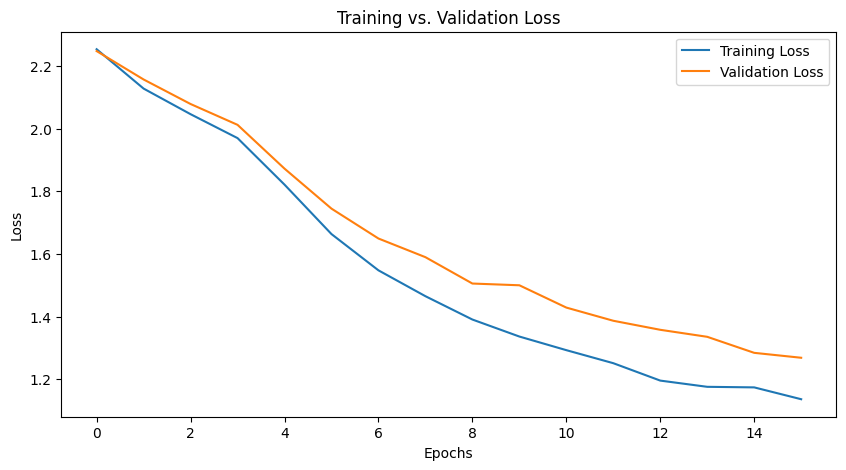

In [19]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## --- Model Testing ---

In [20]:
# Directory paths
test_dir = "/Users/simone/Desktop/Luiss /*Machine Learning/Reply project/Document-classification/Reply_dataset"
tobacco3482_dir = "/Users/simone/Desktop/Luiss/Machine Learning/Reply project/Document-classification/Tobacco3482-10"

In [21]:
# Parameters
img_height, img_width = 128, 128
batch_size = 32

In [22]:
# Data generator for the test set
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2449 images belonging to 10 classes.


### Choose to run just one of the two following code cells to test tuned CNN or regular CNN. Our suggestion is to use the tuned model only if the validation loss is lower than the regular model and at the same time it reaches a better accuracy.

In [ ]:
# Load your trained model
model_load_path = "/Users/simone/Desktop/Luiss /*Machine Learning/Reply project/Document-classification/CNN_tuned.pth"
model = CNN_tuned()
model.load_state_dict(torch.load(model_load_path))
model.eval()  # Set the model to evaluation mode
print(f"Model loaded from {model_load_path}")

In [23]:
# To use not tuned model with its parameters
model_load_path = "/Users/simone/Desktop/Luiss /*Machine Learning/Reply project/Document-classification/CNN.pth"
model = CNN()
model.load_state_dict(torch.load(model_load_path))
model.eval()  # Set the model to evaluation mode
print(f"Model loaded from {model_load_path}")

Model loaded from /Users/simone/Desktop/Luiss /*Machine Learning/Reply project/Document-classification/CNN.pth


In [37]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),  # Convert images in PyTorch tensors
])

In [38]:
# Load the test dataset
test_dataset = datasets.ImageFolder(root='/Users/simone/Desktop/Luiss /*Machine Learning/Reply project/Document-classification/Reply_dataset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [39]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, classification_report

In [40]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # Move data to the correct device
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)
    return test_loss, test_acc, all_preds, all_labels

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (cnn3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=8192, out_features=10, bias=True)
  (dropout4): Dropout(p=0.3, inplace=False)
)

In [42]:
# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

In [43]:
# Evaluate the model
test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

Test Loss: 0.05277011819448506
Test Accuracy: 0.5230706410779911


In [44]:
# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes)

In [48]:
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Confusion Matrix:\n {conf_matrix}")
print(f"Classification Report:\n {class_report}")

Accuracy: 0.5230706410779911
F1 Score: 0.5580912626975286
Precision: 0.7195089490728641
Confusion Matrix:
 [[ 86   0  75  20  33  13 100  18   4  29]
 [  0 240  10  16  32  24   0   4  19   8]
 [  0   1   1   1   2   4   1   1   1   0]
 [  3  26  58  66 140  29   5 108  39  49]
 [  0   8   0   2   3   1   1   2   1   3]
 [  0   3   0   3   3   2   0   3   1   2]
 [  1   5   6   0   6   4   7  14   0   6]
 [  2  34   5   4  26  15   8  29  11  12]
 [  0   9   5   5  17  19   0   4 846  12]
 [  0   5   1   3  13   4   0   3   3   1]]
Classification Report:
                        precision    recall  f1-score   support

                 ADVE       0.93      0.23      0.37       378
                Email       0.73      0.68      0.70       353
                 Form       0.01      0.08      0.01        12
Handwritten documents       0.55      0.13      0.21       523
               Letter       0.01      0.14      0.02        21
                 Memo       0.02      0.12      0.03       

In [49]:
# Normalizing the matrix to range [0, 1]
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

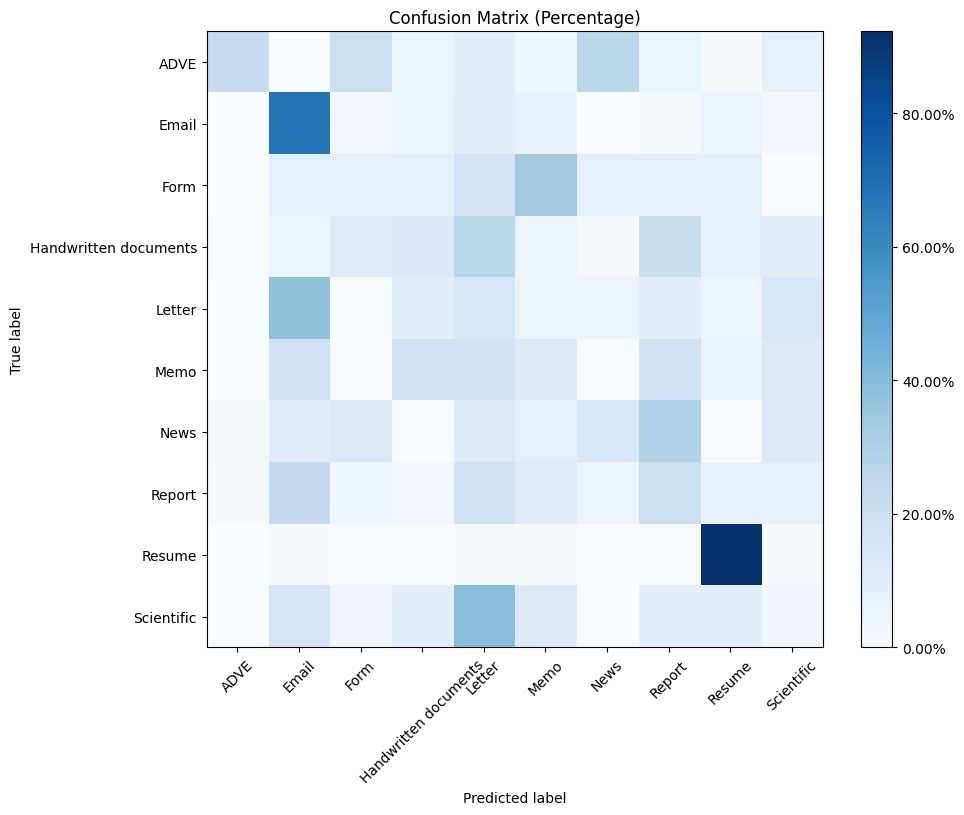

In [51]:
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix_percent, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Percentage)')
plt.colorbar(format='%.2f%%')
tick_marks = np.arange(len(test_loader.dataset.classes))
plt.xticks(tick_marks, test_loader.dataset.classes, rotation=45)
plt.yticks(tick_marks, test_loader.dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()